<img style="border:2px solid black;" src="accueil.png" width=100% border="5"> </center> 
# <span style="color:blue">Porous Media - Flow modelling tools using Jupyter </span>
## <span style="color:red"> PYGRDECL based Upscaling notebook </span>

## <span style="color:blue"> 1. Create initial GRDECL ECLIPSE/PETREL Pillar Grid </span>

In [1]:
from GRDECL2VTK import *

# 1.1 Set physical dimensions in physDims (m)
physDims=[2000.0,1000,500]

# 1.2 Set model grid dimensions in gridDims
Nx=50;  Ny=50;  Nz=Nx
gridDims=[Nx,Ny,Nz]

# 1.3 Set corner point grid options
opt=buildCPGGrid_opt(disturbed=False,     flat=True,\
                     fault_drop=300 , fault_nx=Nx//2)

# 1.4 Create empty GeologyModel - Build CPG
Model=GeologyModel()
Model.buildCPGGrid(physDims,gridDims,opt)

# 1.5 Compute First TPFA (block centered) Pressure values
import time
t0=time.time()
Model.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt)
print("Elapsed time for TPFA: ",time.time()-t0)
Model.plot_scalar("Pressure",ITK=True).show()

     Creating Grid:
       Type: CornerPoint Grid
       Grid Dimensions (NX,NY,NZ): (50 x 50 x 50)
       Number Of Grid Cells: 125000
       Created: Fields: ***PERMX***PERMY***PERMZ***PORO***
Elapsed time for TPFA:  3.6121628284454346
[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 1000000
     NumOfCells 125000
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## <span style="color:blue"> 2. Generate  synthetic Porosity/Permeability(mD) values </span>

[logNormLayers] Filling K and Phi Z layers with log normal distributions
[logNormLayers] Done
[UpdateListCellData] varname:PORO
[UpdateListCellData] varname:PERMX
[UpdateListCellData] varname:PERMY
[UpdateListCellData] varname:PERMZ


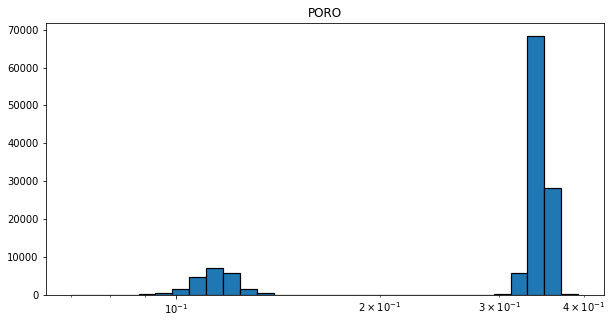

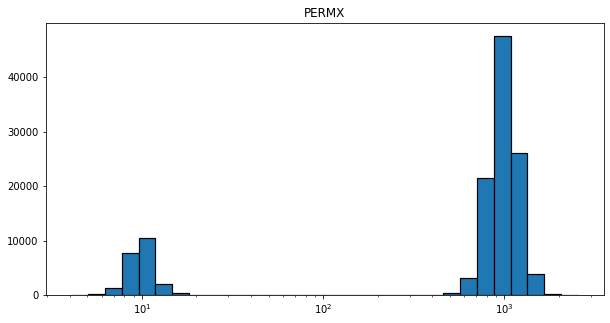

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 1000000
     NumOfCells 125000
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [2]:
from utils import *

# 2.1 Create random perm field with normal distribution for each layer
K_LayerPerm=[1000,10,1000,1000]
# K,phi=logNormLayers(gridDims,K_LayerPerm,poro_const=0.05)
K,phi=logNormLayers_basc(gridDims,K_LayerPerm,poro_const=0.05)

# 2.2 Update porosity/permeability fields
Update_fields=["PORO","PERMX","PERMY","PERMZ"]
Update_values=[ phi  , K     , K     , 0.1*K ]
Model.UpdateListCellData(var_list=Update_fields,array_list=Update_values)

# 2.3 Visualize Fine scale histogram
for scalar in ["PORO","PERMX"]:
    plot_hist(Model.GRDECL_Data.SpatialDatas[scalar], varname=scalar)

# 2.3 Compute TPFA (block centered) Pressure values
Model.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
Model.plot_scalar("Pressure",ITK=True).show()

## <span style="color:blue"> 3. Create coarse grid by partitoning fine gride</span>

[Partioning] Partitoning from Fine grid of size: [50,50,50] to Coarse grid of size: [16,17,17]


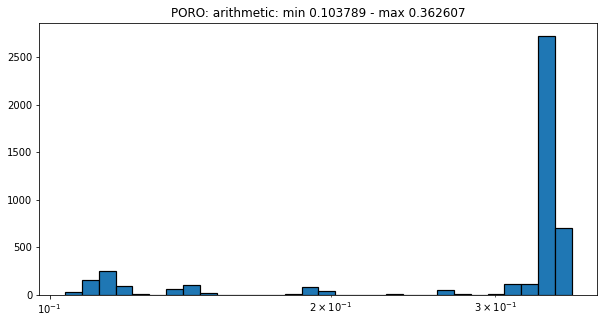

['Arithmetic_mean', 'Geometric_mean', 'Harmonic_mean', 'Harmx_mean', 'Harmy_mean', 'Harmz_mean', 'TPFA_loc', 'TPFA_glob', 'TPFA_loc_vol_average']


In [3]:
# 3.1 Set coarsening factor (grid dimensions of coarse cells)
Model.GRDECL_Data.coarse2fine_ratio=[3]*3

# 3.2 Create coarse grid and upscale porosity
Model2=Model.create_coarse_model()

# List of implemented upscaling methods
methods=Model.Upscaler.list_upscaling_methods()
print(methods)

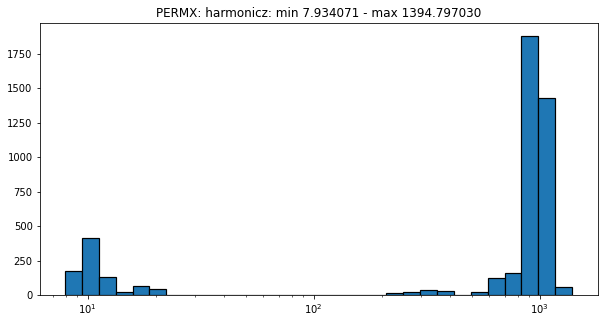

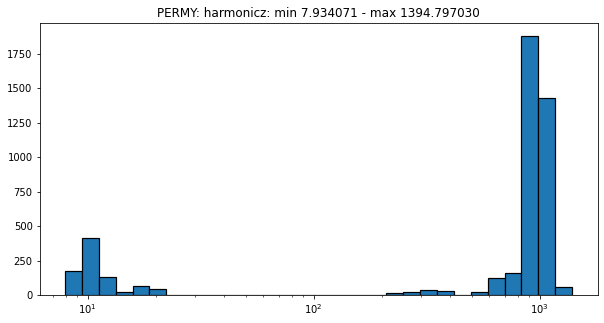

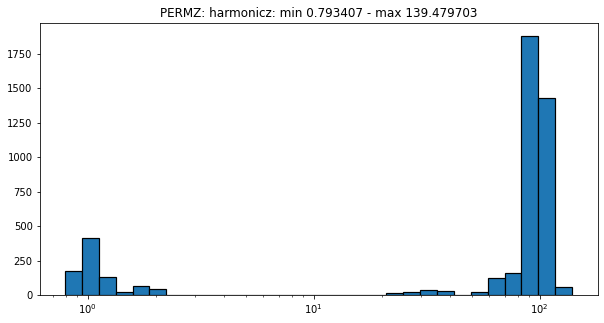

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 36992
     NumOfCells 4624
     .....Done!
[Output] Writing "Results/PILLAR_Grid_Coarse.vtu" Paraview file....Done!


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [4]:
# 3.3 Upscaling
Model.Upscale_Perm('Harmz_mean')

# 3.3 Compute Pressure for coarse model
Model2.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
# # Model.two_plots_scalar("Pressure").show(False)
Model2.plot_scalar("Pressure").show()



[UPSCALING TPFA loc volume average], nlayer: 2


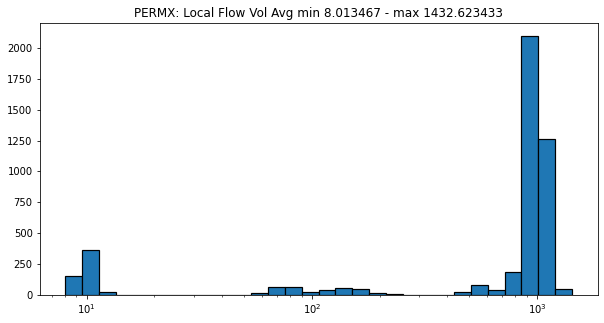

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 36992
     NumOfCells 4624
     .....Done!
[Output] Writing "Results/PILLAR_Grid_Coarse.vtu" Paraview file....Done!


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [8]:
# 3.3 Upscaling
Model.Upscaler.nlayer=2
Model.Upscale_Perm('TPFA_loc_vol_average')

# 3.3 Compute Pressure for coarse model
Model2.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
# # Model.two_plots_scalar("Pressure").show(False)
Model2.plot_scalar("Pressure").show()


In [6]:
# ind=70

# Model.Upscaler.nlayer=0
# Model3=Model.create_local_model(ind)
# Model3.plot_scalar("PORO",ITK=True).show(True)

# Model.Upscaler.nlayer=1
# Model3b=Model.create_local_model(ind)
# Model3b.plot_scalar("PORO",ITK=True).show(True)